In [5]:
from io import BytesIO
import plotly.express as px
import plotly.graph_objects as go
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import base64
import time
import seaborn as sns
import os
plt.rc('font', family='Malgun Gothic') # For Window
os.getcwd()

'/Users/yangwoolee/git_repo/seoul_bike_dash/dashboard'

In [6]:
filtered_data = pd.read_parquet('/Users/yangwoolee/git_repo/data/220607_bike_record.parquet.gzip')


> ### 기본 함수와 변수들

In [78]:
def raw_data(query_data,val) : 
        quert_st_id1 = query_data[query_data['st_id1']==val]
        quert_st_id2 = query_data[query_data['st_id2']==val]
        filtered_data = pd.concat([quert_st_id1,quert_st_id2],axis=0).drop_duplicates()
        filtered_data.drop(columns='index',inplace=True)
        bm = (filtered_data['st_id1'] == val) & (filtered_data['st_id2'] == val)
        filtered_data = filtered_data[~bm]
        # filtered_data.reset_index(drop=True, inplace=True)

        # 대여
        filtered_data_start = filtered_data[(filtered_data['st_id1'] ==val) & (filtered_data['st_id2'] !=val)]

        # 반납
        filtered_data_end = filtered_data[(filtered_data['st_id2'] ==val) & (filtered_data['st_id1'] !=val)]
        
        return [filtered_data,filtered_data_end,filtered_data_start]

test_data = raw_data(filtered_data, 754)

bike_info = pd.read_csv('/Users/yangwoolee/git_repo/data/static/options.csv', encoding='CP949')

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

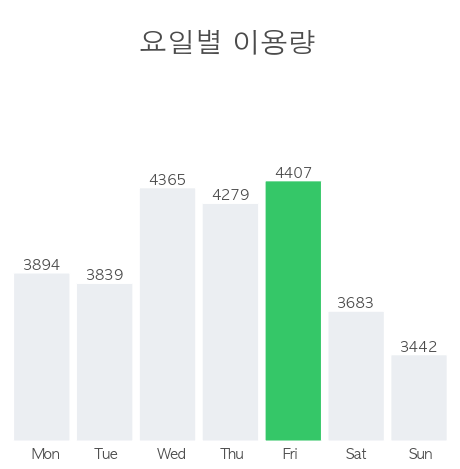

In [219]:
def day_rent(filtered_data) :
    # 일별 자전거 대여
    filtered_data = filtered_data[0]
    filtered_data['weekday'] = filtered_data['date'].dt.weekday
    data = filtered_data.groupby('weekday').size()
    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    # 사각형 정보
    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.9] # x,y,h,w
        bars.append(ist)
    #날짜
    days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    # days = ["월","화","수","목","금","토","일"]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, days) in enumerate(zip(bars, days)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = '#35C768' # full color, font-color
        # 나머지
        else : 
            color = '#EBEEF2' # full color, font-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.0",
            ec="none", fc=color,
            mutation_aspect= 0.5,
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(x+0.28, y-0.1, days, fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

        # 개수 넣기
        plt.text(x+0.15,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

    plt.text(2,2.25, '요일별 이용량', fontdict={'fontsize' : 28, 'color' :(0, 0, 0, 0.7)})
    plt.xlim(-0.1,7) # 넓이가 0.8이라서 그럼
    plt.ylim(0,2.5)
    plt.axis('off')
    # plt.close()

    # return fig

day_rent(test_data)

> ### time

(-0.1, 7.0, 0.0, 2.6)

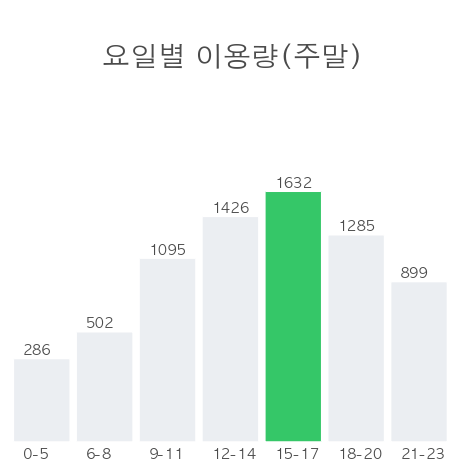

In [222]:
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

# 평일 주말 구분
weekday = raw_data.dt.weekday.isin([0,1,2,3,4])
weekend = raw_data.dt.weekday.isin([5,6])
asd ='주말'

a = raw_data[weekend].dt.hour
bins = [-1, 5, 8, 11, 14, 17, 20, 23]
time=['0-5','6-8','9-11','12-14','15-17','18-20','21-23']
data = a.groupby(pd.cut(a, bins=bins, labels=time)).size()
data_numpy = data.to_numpy()

# max 요일
max_value= np.where(data_numpy == data_numpy.max())[0][0]

# 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

bars = []
for num, h in enumerate(height) :
    ist = [num,0,h,0.9] # x,y,h,w
    bars.append(ist)

# plot
fig, ax = plt.subplots(figsize=(8,8))

# bar = rect
for num,(bar, time) in enumerate(zip(bars, time)) :
    x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
    #max
    if num == max_value :
        color = '#35C768' # bg-color
    # 나머지
    else : 
        color = '#EBEEF2' # bg-color
    
    bbox = patches.FancyBboxPatch(
        (x,y),w,h,
        boxstyle="round,pad=-0.01,rounding_size=0.0",
        ec="none", fc=color,
        mutation_aspect= 0.5,
    )
    ax.add_patch(bbox)

    # 요일 넣기(padding고려해서 num으로 조정)
    plt.text(x+0.15,y-0.1, time, fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

    # 개수 넣기
    plt.text(x+0.15,h+0.02, data[num], fontdict={'fontsize' : 14, 'color' :(0, 0, 0, 0.7)})

    # 시간별 이용량
plt.text(1.4,2.25, f'시간별 이용량({asd})', fontdict={'fontsize' : 28, 'color' :(0, 0, 0, 0.7)})


plt.xlim(-0.1,7) # 넓이가 0.8이라서 그럼
plt.ylim(0,2.6)
plt.axis('off')


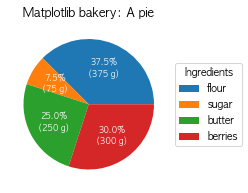

In [226]:
def total_rent(filtered_data) :
    # 데이터 정제
    a = len(filtered_data[1])
    b = len(filtered_data[2])
    percent = int(a / (a + b) * 100)

    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

    recipe = ["375 g flour",
            "75 g sugar",
            "250 g butter",
            "300 g berries"]

    data = [float(x.split()[0]) for x in recipe]
    ingredients = [x.split()[-1] for x in recipe]


    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:d} g)".format(pct, absolute)


    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                    textprops=dict(color="w"))
                                    
    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Matplotlib bakery: A pie")

    plt.show()

total_rent(test_data)

> ### Class Test 중

In [126]:
val = 754
BM = (df['st_id1'] == val) | (df['st_id2'] == val )
filtered_data = df[BM]

In [151]:
# 변수 보기
# class stationInformation(models.Model) : 
#     st_id = models.IntegerField(db_index=True)
#     st_name = models.CharField(max_length=40)
#     district = models.CharField(max_length=10)
#     latitude  = models.FloatField()
#     longtitude  = models.FloatField()

# class station_near_subway(models.Model) : 
#     bi_st_id = models.IntegerField()
#     sub_st_id = models.IntegerField(null=True)
#     sub_name = models.CharField(max_length=20,null=True) 
#     sub_line = models.CharField(max_length=10,null=True) 
#     sub_long = models.FloatField(null=True)         
#     sub_lat = models.FloatField(null=True)      
# 
# 
# class seoul_bike_2021(models.Model) :
#     date = models.DateField()         
#     weekday = models.IntegerField()      
#     by_id = models.IntegerField()        
#     st_id1 = models.IntegerField(db_index=True)       
#     st_id2 = models.IntegerField(db_index=True)       
#     riding_time = models.IntegerField()  
#     dist = models.FloatField()         
#     m_pm = models.FloatField()    

stat_id = 754
include_st=300
filter_start = "대여소"
"""
목적 : 해당 대여소 + 주변 300m 대여소를 찾고 관련 기록을 모은다.

stat_id : 기준 대여소
rank_substation : 보여줄 지하철역 개수
incldue_st : 기준 대여소 600미터 내 대여소 검색

return : 1 to 2 이동 정보, 2 to 1 이동 정보, 시간정보
"""
# 따릉이 대여소 정보
station = pd.read_csv(
    "static/seoul_bike_station_01_12.csv", encoding="CP949")  
# 지하철역 인근 따릉이 대여소 정보
near_sub = pd.read_csv(
    "static/near_sub_station.csv", encoding="CP949")


### 주변지역 포함하는 매소드.. query 시간이 단축되지 않는 이상은 쓰기 어려울듯..

# # stat_id 기준으로 반경 600m 내 대여소 찾기
# distance = haversine_np(
#     station.loc[station["st_id"] == stat_id, "longtitude"].values, # id
#     station.loc[station["st_id"] == stat_id, "latitude"].values,
#     station["longtitude"].values, # 경도
#     station["latitude"].values,
# )
# a = station.copy()
# a["distance"] = distance
# a.dropna(inplace=True)

# # 대여소 검색 결과
# ids = (
#     a.query("distance < @include_st").sort_values(by="distance")["st_id"].tolist()
# )  

# # 검색된 대여소 id 출력
# print(f"{stat_id} 대여소 기준 {include_st}m 반경 내 대여소 : {ids}")

# # seoul_bike에서 해당 대여소 자료만 추출(자료 검색을 빠르게 하기 위함!)
# reduce_case = []
# for st_id in ids:
#     BM = (filtered_data["st_id1"] == st_id) | (filtered_data["st_id2"] == st_id)
#     sort_754 = filtered_data[BM]

#     # 대여소 이동이 없는 경우 제거 ex) 754 => 754
#     minus = sort_754.query("st_id1 == @st_id & st_id2 == @st_id").index
#     sorting = sort_754[~sort_754.index.isin(minus)]
#     reduce_case.append(sorting)

# # 이제는 원본 자료가 아닌 sorted_station을 가지고 이동량 계산
# sorted_station = pd.concat(reduce_case, axis=0)



> ### plotly 가지고오기

In [9]:
class recommend_sub_station :

    def __init__(self, filtered_data, stat_id ,near_sub, station) :
        '''

        해당 대여소에서 자주 이용하는 지하철역과 그 주변에 있는 따릉이 대여소를 추천하는 매서드임.
        filtered_data는 원하는 대여소가 sorting 된 DataFrame이 필요함.
        
        filter_start는 "대여소" 또는 "역"만 올 수 있음.

        '''
        # utils에서는 풀기
        # filtered_data = filtered_data[0]

        # ex) 기준대여소 to 다른 대여소 (1to2)
        total_num_left = filtered_data[filtered_data["st_id1"] == stat_id]["st_id2"].value_counts()  

        # ex) 다른 대여소 to 기준대여소 (2to1)
        total_num_right = filtered_data[filtered_data["st_id2"] == stat_id]["st_id1"].value_counts()

            # 1to2, 2to1 합치기
        combine_values = pd.concat([total_num_left, total_num_right], axis=1)
        combine_values.fillna((1), inplace=True)
        combine_values.rename(columns=dict(st_id2="1to2", st_id1="2to1"), inplace=True)

        # 계산 결과 종합
        result_concat = (
            combine_values.reset_index().groupby("index")[["1to2", "2to1"]].sum()
        )

        # 역 주변 대여소가 검색될 때 해당역 주변 대여소는 제거한다. | 316 대여소는 종각역과 관련됐는데, 종각과 관련된 대여소는 제거했다.
        try:
            filter_sub = near_sub.query("bi_st_id == @stat_id")["sub_name"].iloc[0]
            filter_sub_2 = near_sub.query("sub_name ==@filter_sub")["bi_st_id"].values
            result_concat = result_concat[~result_concat.index.isin(filter_sub_2)]
        except:
            pass


        # 대여소 별로 총 이동 횟수
        result_concat["total"] = abs(
            (result_concat["1to2"] + result_concat["2to1"])
        ) 

        # 지하철역 인근 따릉이 대여소 정보와 종합
        sub_bike = pd.merge(
            result_concat,
            near_sub,
            how="left",
            left_on=result_concat.index,
            right_on="bi_st_id",
        )

        # 지하철역 없는 따릉이 제거 
        sorted_sub = sub_bike.dropna(subset=["sub_st_id"]).sort_values(
            by="total", ascending=False
        ).dropna(subset=['sub_name'])

        # 기록 50건 이하 제거
        count_rent = 50
        sorted_sub = sorted_sub[(sorted_sub['1to2'] > count_rent) | (sorted_sub['2to1'] > count_rent) ]

        # 기준 대여소와 역근처 대여소 직선 거리계산
        station_lat_lon = station[station["st_id"].isin(sorted_sub["bi_st_id"])][
            ["st_id", "st_name", "latitude", "longtitude"]
        ]

        dist_to_station = haversine_np(
            station.loc[station["st_id"] == stat_id, "longtitude"].values,
            station.loc[station["st_id"] == stat_id, "latitude"].values,
            station_lat_lon["longtitude"].values,
            station_lat_lon["latitude"].values,
        )
        station_lat_lon["distance"] = dist_to_station

        #  해당 대여소와의 거리정보 종합
        sorted_sub = pd.merge(
            sorted_sub, station_lat_lon, left_on="bi_st_id", right_on="st_id"
        ).drop(columns=["st_id"])

        # 대여소별 예상 도착시간 계산
        result_station = []
        for station_id in sorted_sub["bi_st_id"]:

            # 대여소 기준 해당 역으로 가는 시간
            BM = filtered_data["st_id2"] == station_id
            st_id1_time = (
                filtered_data[BM]["riding_time"]
                .value_counts()
                .sort_values(ascending=False)
            )
            mean_id1 = round(st_id1_time.index[:3].values.mean(), 1)

            # 해당 역에서 대여소로 가는 시간
            BM = filtered_data["st_id1"] == station_id
            st_id2_time = (
                filtered_data[BM]["riding_time"]
                .value_counts()
                .sort_values(ascending=False)
            )
            mean_id2 = round(st_id2_time.index[:3].values.mean(), 1)

            # st_id1_time.plot.bar()
            result_station.append([mean_id1, mean_id2])


        # 예상시간정보 종합(대여소: 대여소에서 출발)
        est_time = pd.DataFrame(result_station, columns=["대여소", "역"])

        # return 자료 생성
        self.nearest_sub = pd.concat([sorted_sub.reset_index(drop=True), est_time], axis=1)

        if filter_start == "대여소":
            sub_sorted_station = (
                self.nearest_sub.groupby("sub_name")["1to2"]
                .sum()
                .sort_values(ascending=False)
                .reset_index(drop=False)
            )  # 대여소 별 이동량 종합
            counts = "1to2"

        elif filter_start == "역":
            sub_sorted_station = (
                self.nearest_sub.groupby("sub_name")["2to1"]
                .sum()
                .sort_values(ascending=False)
                .reset_index(drop=False)
            )
            counts = "2to1"

        # 역 이름 추출
        self.name_sub = sub_sorted_station["sub_name"].tolist()



    def table_info(self, filter_start='대여소') :

        # 대여소 예상시간 테이블 만들기
        nearest_sub_sorted = (
            self.nearest_sub[["bi_st_id","sub_name", counts, f"{filter_start}"]]
            .sort_values(by=f"{filter_start}")
            .query("sub_name == @name_sub")
            .reset_index(drop=True)
        )
        nearest_sub_sorted.columns = ["대여소 번호", "역사명", "대여기록", "예상시간"]
        # nearest_sub_sorted = nearest_sub_sorted.query("대여기록 > 50").copy()

        nearest_sub_sorted["예상시간"] = nearest_sub_sorted["예상시간"].apply(
            lambda x: str(int(x)) + "분"
        )
        nearest_sub_sorted["대여기록"] = nearest_sub_sorted["대여기록"].apply(
            lambda x: str(int(x)) + "건"
        )

        return nearest_sub_sorted

    def plotly_image(self,filter_start="대여소") : 

        # figure 만들기
        fig = px.scatter_mapbox(
            self.nearest_sub.query("sub_name == @self.name_sub"),
            lat="latitude",
            lon="longtitude",
            hover_name="sub_name",
            hover_data=["1to2", "2to1", "bi_st_id", f"{filter_start}"],
            color="sub_name",
            opacity=0.5,
            template="seaborn",
            mapbox_style="carto-positron",
            # size='total', size_max=20,
            zoom=12,
            height=500,
        )
        # marker 정보
        fig.for_each_trace(lambda t: t.update(name="<b>" + t.name + "</b>"))
        fig.update_traces(marker={"size": 15})

        # 해당 따릉이 대여소 색 표시
        fig_2 = go.Figure(
            go.Scattermapbox(
                name="대여소",
                lat=station.query("st_id==@stat_id")["latitude"],
                lon=station.query("st_id==@stat_id")["longtitude"],
                mode="markers+text",
                marker={"size": 10, "color": "cyan", "opacity": 0.4},
                text=station.query("st_id==@stat_id")["st_name"].values,
            )
        )

        fig.add_trace(fig_2.data[0])
        fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0),
            mapbox=dict(
            accesstoken="pk.eyJ1IjoieWFuZ29vcyIsImEiOiJjbDNqd2tkN2IwbGdmM2pvNzF0c2M4NnZkIn0.J3IjPYg3w28cGiWkUD7bnA"),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
                x=0.99,
                bgcolor="rgba(223, 235, 223, 0.3)",
            ),
        )
        off_plot = plotly.io.to_html(
            fig, include_plotlyjs=False, full_html=True, include_mathjax=False
        )
        bs = BeautifulSoup(off_plot, features="html.parser")
        div_data = bs.find("div", "plotly-graph-div")
        script_data = (
            bs.find("script")
            .text.replace(" ", "")
            .replace("<br>", "")
            .replace("<extra>", "")
            .replace("</extra>", "")
        )
        context = {"div_data": str(div_data), "script_data": str(script_data)}
        return context

station = pd.read_csv(
    "static/seoul_bike_station_01_12.csv", encoding="CP949")  
# 지하철역 인근 따릉이 대여소 정보
near_sub = pd.read_csv(
    "static/near_sub_station.csv", encoding="CP949")
stat_id = 754
filter_start = '대여소'

recommend_sub_station(filtered_data, stat_id, near_sub, station).plotly_image()

> ### subwaystation table info

In [207]:
def recommend_sub_station(filtered_data, filter_start='대여소') :
    # ex) 기준대여소 to 다른 대여소 (1to2)
    total_num_left = filtered_data[filtered_data["st_id1"] == stat_id]["st_id2"].value_counts()  # 기준 대여소에서 빌리면 주로 향하는 목적지는?

    # ex) 다른 대여소 to 기준대여소 (2to1)
    total_num_right = filtered_data[filtered_data["st_id2"] == stat_id]["st_id1"].value_counts()  # 어떤 대여소에서 기준 대여소로 이동할까?

        # 1to2, 2to1 합치기
    combine_values = pd.concat([total_num_left, total_num_right], axis=1)
    combine_values.fillna((1), inplace=True)
    combine_values.rename(columns=dict(st_id2="1to2", st_id1="2to1"), inplace=True)

    # 계산 결과 종합
    result_concat = (
        combine_values.reset_index().groupby("index")[["1to2", "2to1"]].sum()
    )

    # 역 주변 대여소가 검색될경우 해당 대여소는 제거하기 | 316 대여소는 종각역과 관련됐는데, 종각과 관련된 대여소는 제거했다.
    try:
        filter_sub = near_sub.query("bi_st_id == @stat_id")["sub_name"].iloc[0]
        filter_sub_2 = near_sub.query("sub_name ==@filter_sub")["bi_st_id"].values
        result_concat = result_concat[~result_concat.index.isin(filter_sub_2)]
    except:
        pass


    # 대여소 별 총 이동 횟수
    result_concat["total"] = abs(
        (result_concat["1to2"] + result_concat["2to1"])
    ) 

    # 지하철역 인근 따릉이 대여소 정보와 종합
    sub_bike = pd.merge(
        result_concat,
        near_sub,
        how="left",
        left_on=result_concat.index,
        right_on="bi_st_id",
    )

    # 지하철역 없는 따릉이 제거 
    sorted_sub = sub_bike.dropna(subset=["sub_st_id"]).sort_values(
        by="total", ascending=False
    ).dropna(subset=['sub_name'])

    # 기록 50건 이하 제거
    count_rent = 50
    sorted_sub = sorted_sub[(sorted_sub['1to2'] > count_rent) | (sorted_sub['2to1'] > count_rent) ]

    # 기준 대여소와 역근처 대여소 직선 거리계산
    station_lat_lon = station[station["st_id"].isin(sorted_sub["bi_st_id"])][
        ["st_id", "st_name", "latitude", "longtitude"]
    ]
    return station_lat_lon
    dist_to_station = haversine_np(
        station.loc[station["st_id"] == stat_id, "longtitude"].values,
        station.loc[station["st_id"] == stat_id, "latitude"].values,
        station_lat_lon["longtitude"].values,
        station_lat_lon["latitude"].values,
    )
    station_lat_lon["distance"] = dist_to_station

    #  해당 대여소와의 거리정보 종합
    sorted_sub = pd.merge(
        sorted_sub, station_lat_lon, left_on="bi_st_id", right_on="st_id"
    ).drop(columns=["st_id"])

    # 대여소별 예상 도착시간 계산
    result_station = []
    for station_id in sorted_sub["bi_st_id"]:

        # 대여소 기준 해당 역으로 가는 시간
        BM = filtered_data["st_id2"] == station_id
        st_id1_time = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )
        mean_id1 = round(st_id1_time.index[:3].values.mean(), 1)

        # 해당 역에서 대여소로 가는 시간
        BM = filtered_data["st_id1"] == station_id
        st_id2_time = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )
        mean_id2 = round(st_id2_time.index[:3].values.mean(), 1)

        # st_id1_time.plot.bar()
        result_station.append([mean_id1, mean_id2])


    # 예상시간정보 종합(대여소: 대여소에서 출발)
    est_time = pd.DataFrame(result_station, columns=["대여소", "역"])


    # return 자료 생성
    nearest_sub = pd.concat([sorted_sub.reset_index(drop=True), est_time], axis=1)
    
    if filter_start == "대여소":
        sub_sorted_station = (
            nearest_sub.groupby("sub_name")["1to2"]
            .sum()
            .sort_values(ascending=False)
            .reset_index(drop=False)
        )  # 대여소 별 이동량 종합
        counts = "1to2"

    elif filter_start == "역":
        sub_sorted_station = (
            nearest_sub.groupby("sub_name")["2to1"]
            .sum()
            .sort_values(ascending=False)
            .reset_index(drop=False)
        )
        counts = "2to1"

    # 역 이름 추출
    name_sub = sub_sorted_station["sub_name"].tolist()

    # 대여소 예상시간 테이블 만들기
    nearest_sub_sorted = (
        nearest_sub[["bi_st_id","sub_name", counts, f"{filter_start}"]]
        .sort_values(by=f"{filter_start}")
        .query("sub_name == @name_sub")
        .reset_index(drop=True)
    )
    nearest_sub_sorted.columns = ["대여소 번호", "역사명", "대여기록", "예상시간"]
    # nearest_sub_sorted = nearest_sub_sorted.query("대여기록 > 50").copy()

    nearest_sub_sorted["예상시간"] = nearest_sub_sorted["예상시간"].apply(
        lambda x: str(int(x)) + "분"
    )
    nearest_sub_sorted["대여기록"] = nearest_sub_sorted["대여기록"].apply(
        lambda x: str(int(x)) + "건"
    )

    return nearest_sub_sorted

recommend_sub_station(filtered_data, filter_start='대여소')

In [22]:
def raw_data(query_data , val : int) : 
    # BM = (df['st_id1'] == val) | (df['st_id2'] == val )
    # filtered_data = df[BM]

    # 대여
    filtered_data_start = query_data[(query_data['st_id1'] ==val) & (query_data['st_id2'] !=val)]

    # 반납
    filtered_data_end = query_data[(query_data['st_id2'] ==val) & (query_data['st_id1'] !=val)]
    
    return [query_data,filtered_data_end,filtered_data_start]

> ### 일별 자전거 대여

ax.patches => 개별 bar 정보(x,y,h,w)를 확인할 수 있음.

ax.patches[0].patch.get_bbox() 확인한 정보를 변수로 불러올 수 있음
> https://stackoverflow.com/questions/61568935/seaborn-barplot-with-rounded-corners

print(p.properties()) <= 정보를 불러오는 기능인듯 

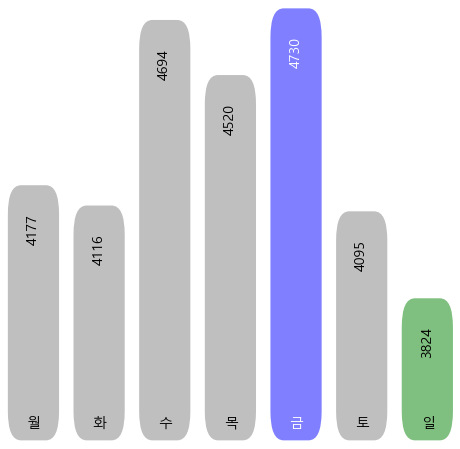

In [39]:
def day_rent(filtered_data :list) :
    # 일별 자전거 대여
    data = filtered_data[0].groupby('weekday').size()

    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]
    max_value

    # min 요일
    min_value= np.where(data_numpy == data_numpy.min())[0][0]
    min_value

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    # 사각형 정보
    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.8] # x,y,h,w
        bars.append(ist)
    #날짜
    days = ["월","화","수","목","금","토","일"]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, days) in enumerate(zip(bars, days)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = ['blue','white'] # full color, font-color
        #min
        elif num == min_value : 
            color = ['green','black'] # full color, font-color
        # 나머지
        else : 
            color = ['gray','black'] # full color, font-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.2",
            ec="none", fc=color[0],
            mutation_aspect= 0.5,
            alpha=0.5
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(x+0.3,y+0.05, days, fontdict={'fontsize' : 14, 'color' : color[1]})

        # 개수 넣기
        plt.text(x+0.3,h-0.2, data[num],rotation=90, fontdict={'fontsize' : 14, 'color' : color[1]})


    plt.xlim(0,6.8) # 넓이가 0.8이라서 그럼
    plt.ylim(0,1.5)
    plt.axis('off')
    # plt.close()


day_rent(raw_data)

> ### 시간대별 이용 비교

In [88]:
BM = (df['st_id1'] == val) | (df['st_id2'] == val )
query_data = df[BM]

In [ ]:
query_data['time'] =  '2021-01-01 ' + query_data['date'].dt.time.apply(str)
query_data

# query_data[']
test_count = query_data.groupby([pd.Grouper(key='time',freq='H')]).size()
test_count

In [ ]:
def day_rent(filtered_data :list) :
    # 일별 자전거 대여
    data = filtered_data[0].groupby('weekday').size()

    data_numpy = data.to_numpy()

    # max 요일
    max_value= np.where(data_numpy == data_numpy.max())[0][0]
    max_value

    # min 요일
    min_value= np.where(data_numpy == data_numpy.min())[0][0]
    min_value

    # 높이 normalize 후 0.5 더함( 0.5는 막대 길이를 의미함)
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    # 사각형 정보
    bars = []
    for num, h in enumerate(height) :
        ist = [num,0,h,0.8] # x,y,h,w
        bars.append(ist)
    #날짜
    days = ["월","화","수","목","금","토","일"]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))

    # bar = rect
    for num,(bar, days) in enumerate(zip(bars, days)) :
        x = bar[0]; y = bar[1]; h = bar[2];  w = bar[3]
        #max
        if num == max_value :
            color = ['blue','white'] # full color, font-color
        #min
        elif num == min_value : 
            color = ['green','black'] # full color, font-color
        # 나머지
        else : 
            color = ['gray','black'] # full color, font-color
        
        bbox = patches.FancyBboxPatch(
            (x,y),w,h,
            boxstyle="round,pad=-0.01,rounding_size=0.2",
            ec="none", fc=color[0],
            mutation_aspect= 0.5,
            alpha=0.5
        )
        ax.add_patch(bbox)

        # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(x+0.3,y+0.05, days, fontdict={'fontsize' : 14, 'color' : color[1]})

        # 개수 넣기
        plt.text(x+0.3,h-0.2, data[num],rotation=90, fontdict={'fontsize' : 14, 'color' : color[1]})


    plt.xlim(0,6.8) # 넓이가 0.8이라서 그럼
    plt.ylim(0,1.5)
    plt.axis('off')
    # plt.close()


day_rent(raw_data)

> ### 자주 이용하는 대여소

[[0, 0, 1, 0.5], [0, 1, 1, 0.6], [0, 2, 1, 1.5]]


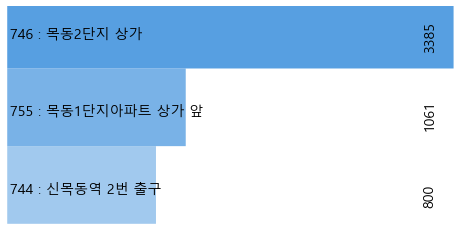

In [37]:
# 반납 : filtered_data_end(=val 1), 대여 : filtered_data_start(=val 2)
def frequent_station(filtered_data,val) :
    data = filtered_data[val].groupby(f'st_id{val}').size().sort_values(ascending=False)[:3]
    data_index = data.index
    labels = [ bike_info.query('st_id == @i')['label'].iloc[0] for i in data_index]
    data_numpy = data.to_numpy()
    height = list(map(lambda x : round(((x-data_numpy.min())/(data_numpy.max()-data_numpy.min()))+0.5,2), data_numpy ))

    bars = []
    for num, w in enumerate(height[::-1]):
        ist = [0, num, 1, w]  # x,y,h,w
        bars.append(ist)
    print(bars)
    # 날짜
    days = ["월", "화", "수", "목", "금", "토", "일"]

    # plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # bar = rect
    for num, (bar, label) in enumerate(zip(bars, labels)):
        x = bar[0]
        y = bar[1]
        h = bar[2]
        w = bar[3]
        color = ["#A1C9EE", "#79B2E7", "#579FE1"]  # full color, font-color
        bbox = patches.FancyBboxPatch(
            (x, y),
            w,
            h,
            boxstyle="round,pad=-0.0001,rounding_size=0",
            ec="none",
            fc=color[num],
            mutation_aspect=0.5,
            # alpha=1
        )
        ax.add_patch(bbox)

        # # 요일 넣기(padding고려해서 num으로 조정)
        plt.text(
            0.01, y + 0.4, f"{label[:20]}", fontdict={"fontsize": 14, "color": "black"}
        )

        # # 개수 넣기
        # len(data)-1-num으로 한 이유는 역순으로 뽑아야 하기때문
        plt.text(
            1.4,
            y + 0.25,
            data.iloc[len(data) - 1 - num],
            rotation=90,
            fontdict={"fontsize": 14, "color": "black"},
        )


    plt.xlim(0, 1.5)  # 넓이가 0.8이라서 그럼
    plt.ylim(0, 2.8)
    plt.axis("off")
    # plt.close()

frequent_station(raw_data,2)


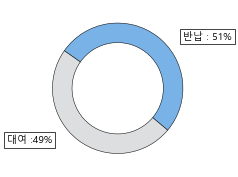

In [38]:
def total_rent(filtered_data) :
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

    # 데이터 정제
    a = len(filtered_data[1])
    b = len(filtered_data[2])
    percent = int(a / (a + b) * 100)

    # plot에 필요한 변수 설정
    tag = [f"반납 : {percent}%", f"대여 :{100-percent}%"]
    data = [a, b]
    wedge_properties = {"edgecolor": "k", "linewidth": 2}
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(bbox=bbox_props, zorder=0, va="center")

    # pie plot
    wedges, texts = ax.pie(
        data,
        wedgeprops=dict(width=0.3, edgecolor="k", linewidth=0.5),
        startangle=-40,
        colors=["#79B2E7", "#DCDEDF"],
    )

    # annotation 설정
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        # kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            tag[i],
            xy=(x, y),
            xytext=(1 * np.sign(x), 1 * y),
            horizontalalignment=horizontalalignment,
            **kw,
        )
        ax.text(-0.4, 0.05, "대여소 이용", fontdict={"color": "white"})
        ax.text(-0.3, -0.15, f"{a+b}건", fontdict={"color": "white"})

    # ax.set_title("Matplotlib bakery: A donut")

    # plt.close()

total_rent(raw_data)